# Plot an instrument data vs another

Generic libraries:

In [1]:
from functools import partial
from pathlib import Path
import tomllib

import numpy as np

Other libraries required for this notebook:

In [2]:
from multipac_testbench.multipactor_test import MultipactorTest
import multipac_testbench.instruments as ins
from multipac_testbench.util.post_treaters import running_mean
from multipac_testbench.util.multipactor_detectors import \
    quantity_is_above_threshold

Define the project path, load the configuration.

In [3]:
project = Path("../data/campaign")
config_path = Path(project, "testbench_configuration.toml")

with open(config_path, "rb") as f:
    config = tomllib.load(f)

In [4]:
filepath = Path(project, "120MHz_SWR4.csv")
multipactor_test = MultipactorTest(filepath,
                                   freq_mhz=120.,
                                   swr=4.,
                                   config=config,
                                   sep='\t')

Here we want to have the `FieldProbe` on x-axis, and current measured at same position, same time steps.
We exclude the field probe at E1, as its data was not realistic. Also remove corresponding current probe to avoid mismatch.

In [5]:
exclude = "NI9205_E1", "NI9205_MP1l"
x_instrument = ins.FieldProbe
y_instrument = ins.CurrentProbe
figsize = (8, 8)

Smooth the current data

In [6]:
current_smoother = partial(
    running_mean,
    n_mean=10,
    mode='same',
)

multipactor_test.add_post_treater(
    current_smoother,
    ins.CurrentProbe,
)

Set a multipactor detection criterion:

In [7]:
current_multipactor_criterions = {'threshold': 12.,
                                  'consecutive_criterion': 10,
                                  'minimum_number_of_points': 7}
current_multipac_detector = partial(quantity_is_above_threshold,
                                    **current_multipactor_criterions)
current_multipactor_bands = multipactor_test.detect_multipactor(
    current_multipac_detector,
    ins.CurrentProbe,
)

Check that detected multipactor zones are consistent:

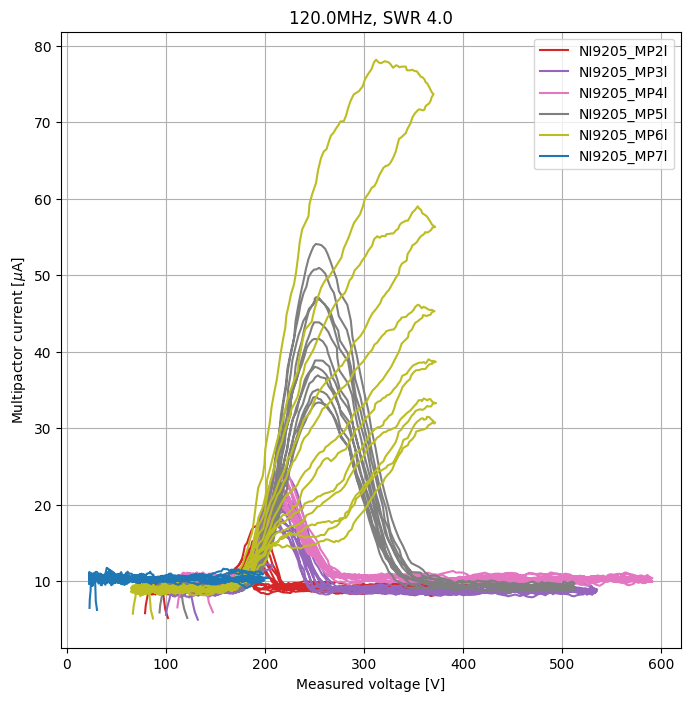

In [8]:
_, _ = multipactor_test.sweet_plot(
    y_instrument,
    xdata=x_instrument,
    exclude=exclude,
    figsize=figsize,
)

It is possible to take only the `tail` last points:

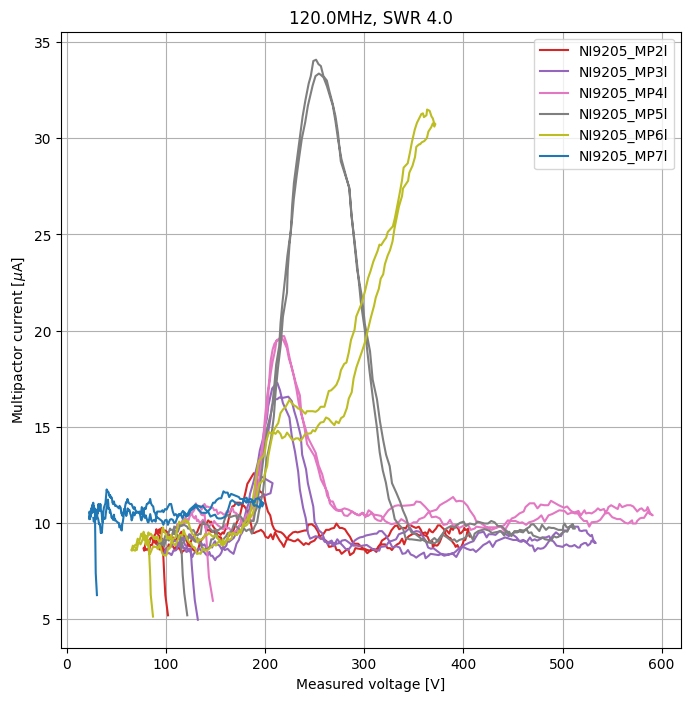

In [9]:
tail = 350  # this is approximatively the two last half-power cycles
_, _ = multipactor_test.sweet_plot(
    y_instrument,
    xdata=x_instrument,
    exclude=exclude,
    figsize=figsize,
    tail=tail,
)